## Loading and pre-processing the data

First, we'll load the data from the "factory_test.csv" file.
The data is consisted of 9 columns, marked Y1 - Y5, and X2 - X5, and each Y value has a corresponding X value, except for the first one.
The data has some corrupted entries, so we'll have to pre-process it and remove them.

In [131]:
import sys
import matplotlib.pyplot as plt

sys.path.append("../")
from utils import *

factory_df = pd.read_csv("./factory_test_data.csv")
new_samples = pd.read_csv("./new_devices.csv")

Now, we'll remove the broken entries and display the relevant data.
Looking at the data, it's easy to see that every bad entry has '[]' instead of a numeric value in every cell except Y1, so filtering according to one of those columns and filtering according to non-numeric values should do the trick.

In [132]:
factory_df['Y2'] = pd.to_numeric(factory_df['Y2'], errors='coerce')
factory_df = factory_df.dropna(subset=['Y2'])
factory_df = factory_df.astype('float64')
factory_df.head()

,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5
0,1491.0,18.0,16.80,14.0,13.33,12.0,11.12,9.0,8.33
2,2004.0,18.0,17.94,14.0,13.99,12.0,11.72,9.0,8.65
4,1497.0,18.0,18.00,14.0,13.59,12.0,12.91,9.0,7.82
5,1498.0,18.0,7.87,14.0,13.52,12.0,11.51,9.0,8.29
6,1492.0,18.0,20.23,14.0,13.41,12.0,9.73,9.0,8.58


We'd like to have some knowledge of the basic statistics for each feature, and try to understand the data's spread and central tendency.

In [133]:
summary_statistics = {
    'Mean': factory_df.mean(),
    'Median': factory_df.median(),
    'Standard Deviation': factory_df.std(),
    'Minimum': factory_df.min(),
    'Maximum': factory_df.max(),
}

summary_df = pd.DataFrame(summary_statistics)
print(summary_df)

           Mean   Median  Standard Deviation  Minimum  Maximum
Y1  1505.957447  1495.00           74.335011  1487.00  2004.00
X2    18.000000    18.00            0.000000    18.00    18.00
Y2    17.425957    18.00            4.275727     7.87    25.26
X3    14.000000    14.00            0.000000    14.00    14.00
Y3    13.452340    13.45            0.123732    13.19    13.99
X4    12.000000    12.00            0.000000    12.00    12.00
Y4    11.673830    11.50            1.226748     9.10    14.56
X5     9.000000     9.00            0.000000     9.00     9.00
Y5     8.346383     8.33            0.295807     7.81     9.16


Looking at the Y1 values, it's noticeable that except for one entry with the value 2004, all the other samples are around 1500. That causes the standard deviation to be very high, and indicates that value is an outlier and should be removed. We'll remove it and recalculate...

In [134]:
factory_df = factory_df[factory_df['Y1'] < 1550]

summary_statistics = {
    'Mean': factory_df.mean(),
    'Median': factory_df.median(),
    'Standard Deviation': factory_df.std(),
    'Minimum': factory_df.min(),
    'Maximum': factory_df.max(),
}

summary_df = pd.DataFrame(summary_statistics)
print(summary_df)

           Mean    Median  Standard Deviation  Minimum  Maximum
Y1  1495.130435  1495.000            4.063981  1487.00  1510.00
X2    18.000000    18.000            0.000000    18.00    18.00
Y2    17.414783    18.075            4.322280     7.87    25.26
X3    14.000000    14.000            0.000000    14.00    14.00
Y3    13.440652    13.445            0.095322    13.19    13.66
X4    12.000000    12.000            0.000000    12.00    12.00
Y4    11.672826    11.495            1.240284     9.10    14.56
X5     9.000000     9.000            0.000000     9.00     9.00
Y5     8.339783     8.315            0.295556     7.81     9.16


## Visualizing the data


The data I've been given has 9 features, which makes it hard to visualize. In order to get a good visualization of it, a good place to start is performing PCA. PCA is a method that allows projecting data into a lower dimension where visualization is possible, and does so by reducing the data to its principal components (most important features in terms of variance and minimizing data loss from dimension reduction). This will give us a first feel in regard to the way the data is distributed.

Principal Component 1:
[ 1.82001986e-01  5.55111512e-17  9.80279443e-01  0.00000000e+00
 -6.24117682e-03  0.00000000e+00  7.60549434e-02  0.00000000e+00
 -1.02070960e-02]
Principal Component 2:
[-9.78443078e-01  2.77555756e-17  1.88237781e-01  0.00000000e+00
 -6.78680505e-03  0.00000000e+00 -8.32504943e-02  0.00000000e+00
  1.54588361e-02]
Principal Component 3:
[ 9.63227869e-02  4.44089210e-16  5.94012843e-02  0.00000000e+00
 -2.84394177e-03  0.00000000e+00 -9.93311284e-01  0.00000000e+00
  2.27598964e-02]


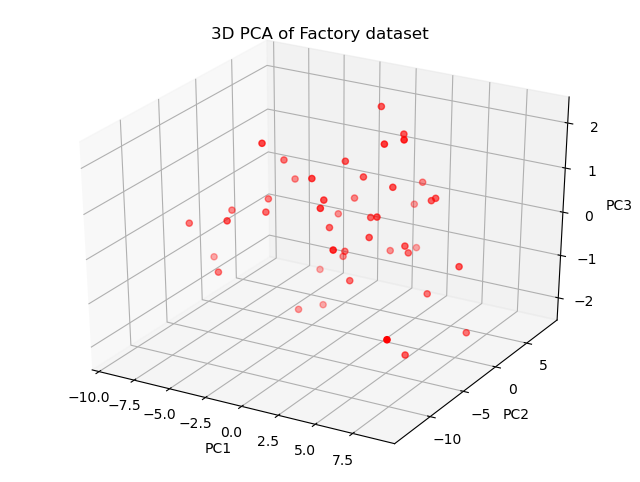

In [135]:
def pca(X, num_components):
    X_np = X.values
    mean = np.mean(X_np, axis=0)
    X_centered = X_np - mean
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    principal_components = sorted_eigenvectors[:, :num_components]
    reduced_data = np.dot(X_centered, principal_components)
    reduced_data_df = pd.DataFrame(reduced_data, columns=[f"PC{i + 1}" for i in range(num_components)])

    return reduced_data_df, principal_components

pca_x, prin_comp = pca(factory_df, 3)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_x['PC1'], pca_x['PC2'], pca_x['PC3'], c="red")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Factory dataset')

for i, pc_vector in enumerate(prin_comp.T, start=1):
    print(f"Principal Component {i}:")
    print(pc_vector)

The coefficients of the principal components show us that the most influential features are Y2 and Y4, which means that their variance is the largest, and they are probably the most impactful ones. The Xi features are constant, so they don't impact the principal components at all.

We'd like to get a sense of the distribution of each feature, for that we'll create a histogram for each one of them.

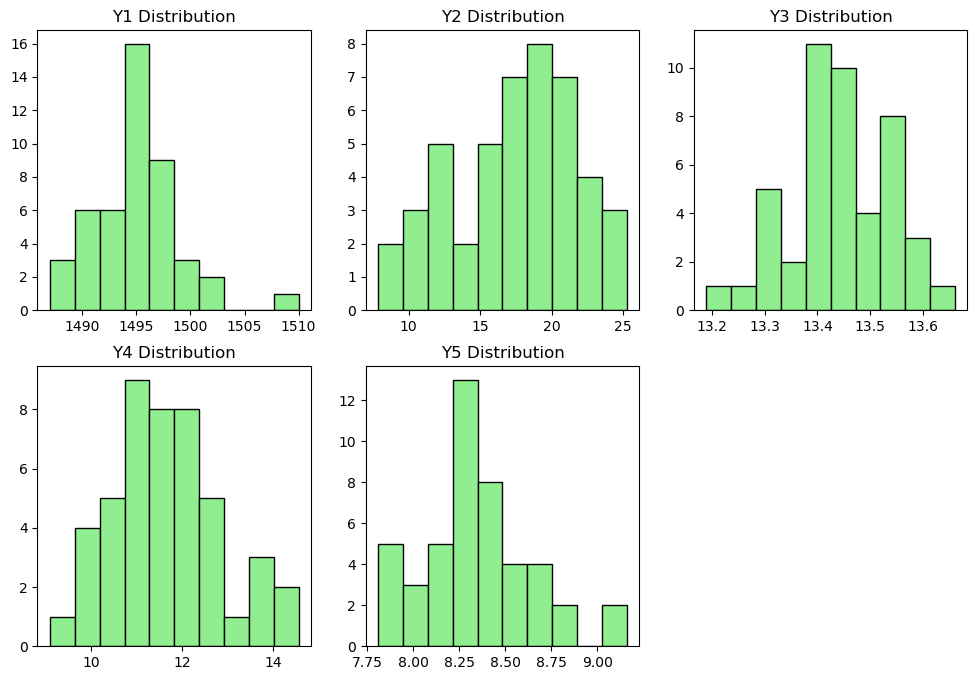

In [136]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))


def create_histogram(ax, feature, row, col, title):
    ax[row, col].hist(feature, bins=10, color='lightgreen', edgecolor='black')
    ax[row, col].set_title(title)


create_histogram(axs, factory_df.iloc[:, 0], 0, 0, "Y1 Distribution")
create_histogram(axs, factory_df.iloc[:, 2], 0, 1, "Y2 Distribution")
create_histogram(axs, factory_df.iloc[:, 4], 0, 2, "Y3 Distribution")
create_histogram(axs, factory_df.iloc[:, 6], 1, 0, "Y4 Distribution")
create_histogram(axs, factory_df.iloc[:, 8], 1, 1, "Y5 Distribution")

fig.delaxes(axs[1, 2])

These graphs show us that some features are very dense around their mean (Y3 for example), while others are more evenly distributed between their maximum and minimum (Y2 or Y4).

Next, we'll calculate the covariance matrix of features to try to answer the question of which features are most correlative with each other, and what is the variance of each feature.

In [137]:
data = factory_df.values
cov_matrix = np.cov(data, rowvar=False)
df_cov = pd.DataFrame(cov_matrix, columns=factory_df.columns, index=factory_df.columns)
print(df_cov)

           Y1   X2         Y2   X3        Y3   X4        Y4   X5        Y5
Y1  16.515942  0.0   0.311140  0.0  0.088357  0.0  1.484290  0.0 -0.281749
X2   0.000000  0.0   0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000
Y2   0.311140  0.0  18.682101  0.0 -0.136532  0.0  1.064953  0.0 -0.137826
X3   0.000000  0.0   0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000
Y3   0.088357  0.0  -0.136532  0.0  0.009086  0.0  0.004171  0.0 -0.000873
X4   0.000000  0.0   0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000
Y4   1.484290  0.0   1.064953  0.0  0.004171  0.0  1.538305  0.0 -0.064084
X5   0.000000  0.0   0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000
Y5  -0.281749  0.0  -0.137826  0.0 -0.000873  0.0 -0.064084  0.0  0.087353


This shows us a few things:
- The feature with the highest variance is Y2, which means fluctuations in its value should be expected.
- There seems to be a high covariance between Y1 and Y4, and between Y2 and Y4. That relationship is worth exploring.
- Y3 has very low variance in the given sample set, this could be useful in predicting whether a new sample belongs to the sample group.

Based on those findings, we'll want to create a scatter plot of the high covariance features.

Text(0.5, 1.0, 'Y4 values as a function of Y2 values')

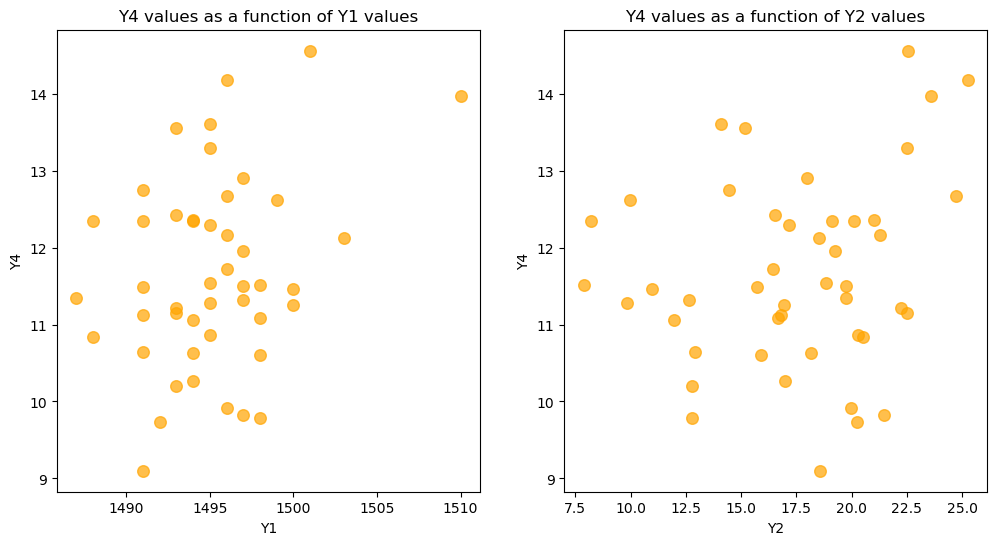

In [138]:
y1_values = factory_df.iloc[:, 0]
y2_values = factory_df.iloc[:, 2]
y3_values = factory_df.iloc[:, 4]
y4_values = factory_df.iloc[:, 6]
y5_values = factory_df.iloc[:, 8]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

marker_style = 'o'
marker_size = 70
marker_color = 'orange'
transparency = 0.7

axs[0].scatter(y1_values, y4_values, marker=marker_style, s=marker_size, c=marker_color, alpha=transparency,
               label='Data Points')

axs[0].set_xlabel('Y1', fontsize=10)
axs[0].set_ylabel('Y4', fontsize=10)
axs[0].set_title('Y4 values as a function of Y1 values', fontsize=12)

axs[1].scatter(y2_values, y4_values, marker=marker_style, s=marker_size, c=marker_color, alpha=transparency,
               label='Data Points')

axs[1].set_xlabel('Y2', fontsize=10)
axs[1].set_ylabel('Y4', fontsize=10)
axs[1].set_title('Y4 values as a function of Y2 values', fontsize=12)

This demonstrates a strong relationship between Y4 and Y1 since we can see their values seem directly proportional. When one goes up, the other one usually goes up too. That proportion is less apparent in the graph showcasing the relationship between Y4 and Y2.

Next, it would be interesting to look at the relationship between the dependent variables and their corresponding independent variables. Since the Xi values are constant in every sample, it would be best to look at the way the Yi values are located around it rather than set one as a function of the other.

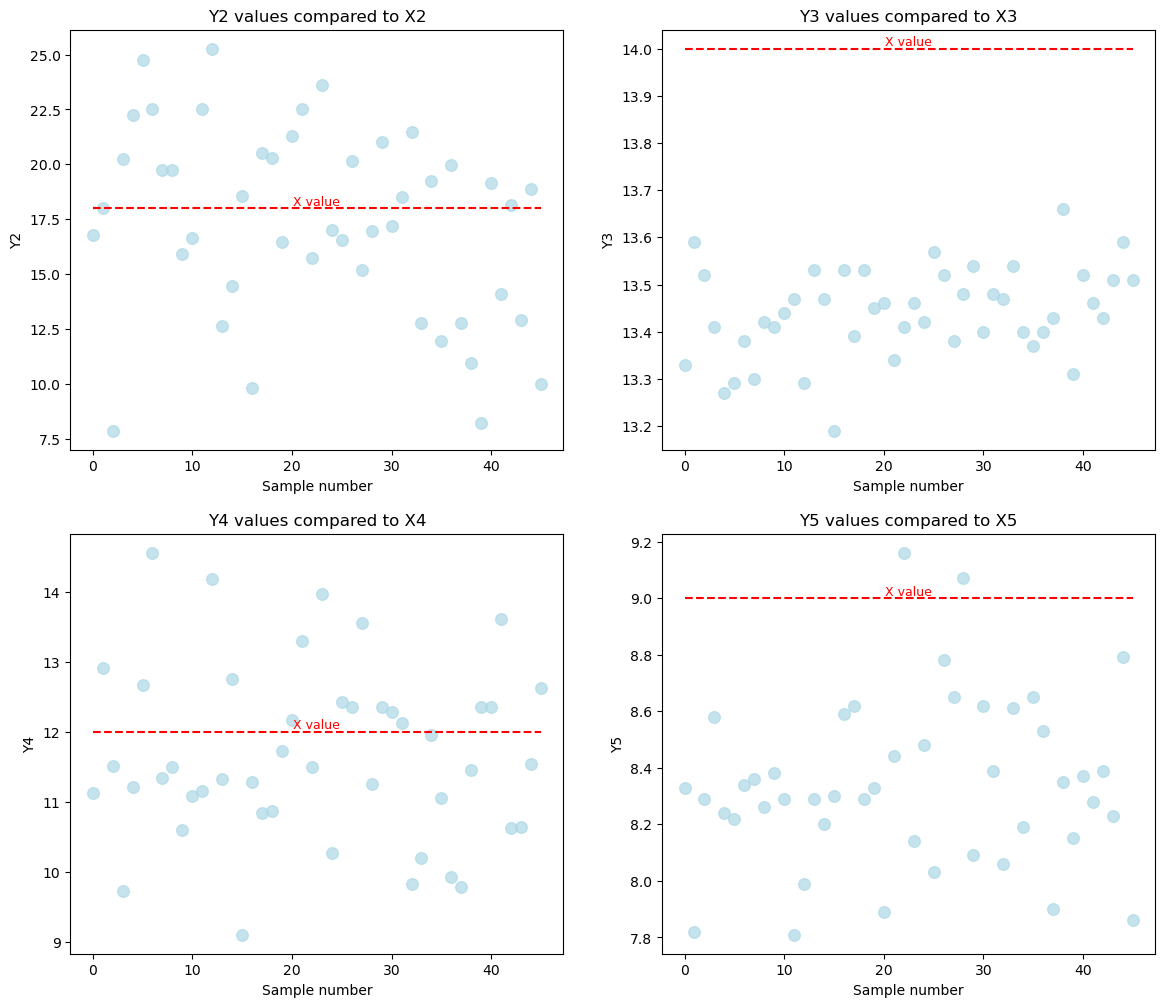

In [139]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

x2_values = factory_df.iloc[:, 1]
x3_values = factory_df.iloc[:, 3]
x4_values = factory_df.iloc[:, 5]
x5_values = factory_df.iloc[:, 7]
marker_color = 'lightblue'

samples = [i for i in range(len(factory_df))]


def create_scatter(ax, row, col, x_label, y_label, title, x_value, y_value, constant):
    ax[row, col].scatter(x_value, y_value, marker=marker_style, s=marker_size, c=marker_color, alpha=transparency,
                         label='Data Points')

    ax[row, col].hlines(y=constant, xmin=min(samples), xmax=max(samples),
                    color='red', linestyle='dashed')
    ax[row, col].text((min(samples) + max(samples)) / 2, constant, 'X value',
                  color='red', fontsize=9, ha='center', va='bottom')

    ax[row, col].set_xlabel(x_label, fontsize=10)
    ax[row, col].set_ylabel(y_label, fontsize=10)
    ax[row, col].set_title(title, fontsize=12)


create_scatter(axs, 0, 0, "Sample number", "Y2", "Y2 values compared to X2", samples, y2_values, x2_values[0])
create_scatter(axs, 0, 1, "Sample number", "Y3", "Y3 values compared to X3", samples, y3_values, x3_values[0])
create_scatter(axs, 1, 0, "Sample number", "Y4", "Y4 values compared to X4", samples, y4_values, x4_values[0])
create_scatter(axs, 1, 1, "Sample number", "Y5", "Y5 values compared to X5", samples, y5_values, x5_values[0])


From these graphs we can understand that while some Y variables can move around their X variables (Y4 and X4, Y2 and X2), some X values can act as a sort of threshold. As we can see, none of the samples had a Y3 value over the X3 value, and only two samples had their Y5 value larger than their X5 value.

This is valuable. If we assume that most devices should pass their factory tests, we can use that threshold as a test for the device.

## Ranking new samples

In order to predict the probabilities of the new samples being from the same sample group, I'd usually choose to train a probabilistic machine learning model on the given samples and compare the responses it gives me for the new samples. In our case, though, we have a very small number of samples to learn from, so any model I'd train is in big danger of being overfitted, so the alternative I'll choose is to define some similarity measure to quantify the similarity between samples, and rank the new samples according to that metric.

I'd like to rank samples that are closest to the mean first, but if I use the l1 norm from the mean for example, I wouldn't "punish" samples that are close to the mean in a few features and very far from it in others enough. so I need a metric that punishes a sample more for being 4 points away from the mean in one feature than being 1 point away from the mean in 4 features.

Another requirement from that metric is to take into account the variance of the features and the covariance between them. A sample is more likely to have been from the same sample group as the factory_test_data if it follows the same trends we saw in the covariance matrix.

A metric that answers both requirements is the Mahalanobis metric, so I'll use that metric. In order to use it, I need my covariance matrix to be invertible, and the X columns are not allowing me that, so I'll remove them for this part.

In [140]:
to_drop = ["X2", "X3", "X4", "X5"]


def calculate_mahalanobis(y=None, data=None, cov=None):
    y_difference = y - np.mean(data)
    inv_covariance_matrix = np.linalg.inv(cov)
    left_mult = np.dot(y_difference, inv_covariance_matrix)
    mahal = np.dot(left_mult, y_difference.T)
    return np.sqrt(mahal)


Y_factory_DF = factory_df.drop(to_drop, axis=1)
Y_new_samples = new_samples.drop(to_drop, axis=1)
Y_new_samples = Y_new_samples.drop("ID", axis=1)

cov_matrix = np.cov(Y_factory_DF, rowvar=False)

mahalanobis_distances = []

for i in range(len(Y_new_samples)):
    mahalanobis_distances.append((i + 1, calculate_mahalanobis(Y_new_samples.iloc[i], Y_factory_DF, cov_matrix)))

print("New samples ranking:")
for i, dist in enumerate(sorted(mahalanobis_distances, key=lambda x: x[1])):
    print(f"{i + 1}. ID: {dist[0]}. Mahalanobis: {dist[1].__round__(3)}.")

New samples ranking:
1. ID: 2. Mahalanobis: 0.555.
2. ID: 3. Mahalanobis: 1.254.
3. ID: 1. Mahalanobis: 16.536.


## Bonus

From what I've gathered of the data, and specifically the connection between the Y variables and the X variables, it seems that the connection between them is the following:
- X2 is the expected mean value of Y2.
- X3 is the maximum threshold for Y3.
- X4 is the expected mean value of Y4.
- X5 is the maximum threshold for Y5.

Thus, the tests should evaluate whether a sample is an outlier in one of the Y features, which means surpassing the threshold in Y2 or Y5, or being too far away from the wanted value in Y3 or Y4.

For my tests I'll choose a threshold for the distance from the expected mean in Y2, Y5 based on my understanding of what is considered "too far", but that value could potentially be changed according to the factory's needs and definitions of failure in a test. My choice will be a deviation of more than 50% from the X value.

In [141]:
x2, x3, x4, x5 = x2_values[0], x3_values[0], x4_values[0], x5_values[0]

y2_min, y2_max = x2 * 0.5, x2 * 1.5
y3_max = x3
y4_min, y4_max = x4 * 0.5, x4 * 1.5
y5_max = x5


def test_df(df):
    return [
        i for i, row in df.iterrows()
        if not (y2_min <= row["Y2"] <= y2_max and row["Y3"] <= y3_max and
                y4_min <= row["Y4"] <= y4_max and row["Y5"] <= y5_max)
    ]


failed_factory = test_df(Y_factory_DF)
failed_new = test_df(Y_new_samples)

print("Failed Factory Samples:", failed_factory)
print("Failed New Samples:", failed_new)


Failed Factory Samples: [5, 27, 33, 44]
Failed New Samples: []
